# Spaceship Titanic

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import xgboost as xgb

**Load the datasets**

In [2]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
# Display the first few rows of the training data
print("Training Data Head:")
print(train_df.head())

Training Data Head:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  

In [4]:
print("\nTraining Data Info:")
print(train_df.info())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


**Data Exploration**

In [5]:
print("\nSummary Statistics:")
print(train_df.describe())


Summary Statistics:
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  


In [6]:
print("\nMissing Values:")
print(train_df.isnull().sum())


Missing Values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


**Visualize the Data**

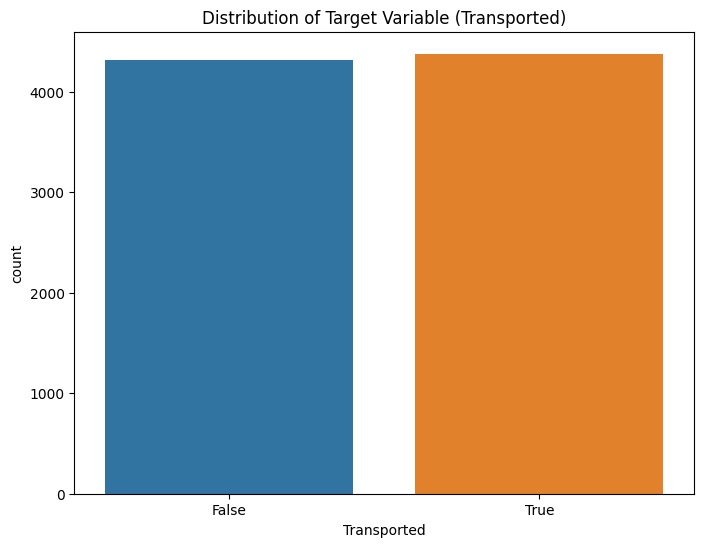

In [7]:
# 1. Distribution of the Target Variable (Transported)
plt.figure(figsize=(8, 6))
sns.countplot(x='Transported', data=train_df)
plt.title('Distribution of Target Variable (Transported)')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


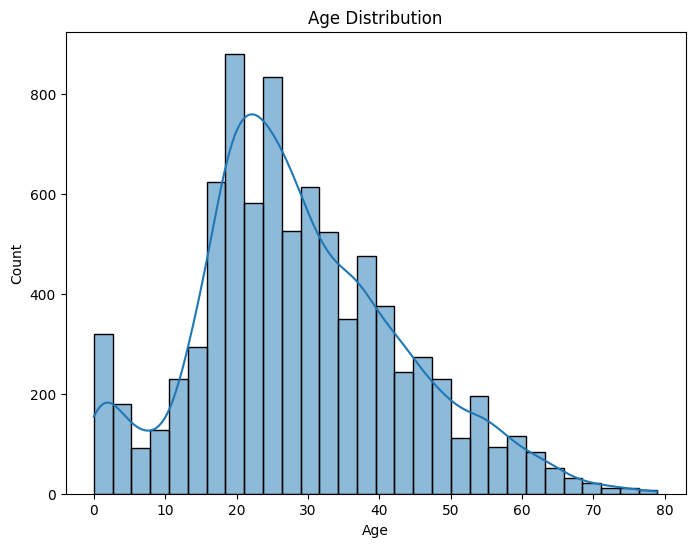

In [8]:
# 2. Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

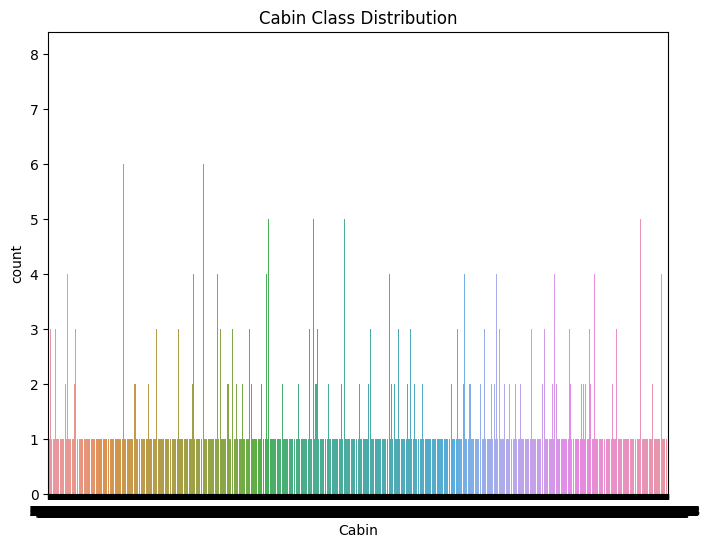

In [9]:
# 3. Cabin Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Cabin', data=train_df)
plt.title('Cabin Class Distribution')
plt.show()

**Data Cleaning and Feature Engineering**

In [10]:
def fill_missing_values(df):
    df['HomePlanet'] = df['HomePlanet'].fillna('Earth')
    df['CryoSleep'] = df['CryoSleep'].fillna(False).infer_objects(copy=False)
    df['Cabin'] = df['Cabin'].fillna('Unknown')
    df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['VIP'] = df['VIP'].fillna(False).infer_objects(copy=False)
    df = df.fillna(0)
    return df

# Apply missing value filling
train_df = fill_missing_values(train_df)
test_df = fill_missing_values(test_df)

# Convert columns to string type to ensure uniformity
label_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
for col in label_cols:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# Combine data from both datasets for fitting the encoder
combined_data = pd.concat([train_df[label_cols], test_df[label_cols]], axis=0)

# Label encoding using combined data
label_encoders = {col: LabelEncoder().fit(combined_data[col]) for col in label_cols}

# Apply label encoding to the train and test sets
for col, le in label_encoders.items():
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Prepare features and target
X = train_df.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train_df['Transported'].astype(int)
X_test = test_df.drop(['PassengerId', 'Name'], axis=1)


/tmp/ipykernel_18/3498877172.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(False).infer_objects(copy=False)
/tmp/ipykernel_18/3498877172.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).infer_objects(copy=False)
/tmp/ipykernel_18/3498877172.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('f

**Model Training**

In [11]:
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train the model
model = xgb.XGBClassifier( n_estimators= 200, learning_rate= 0.1, max_depth = 5)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
# Predict on validation set
y_pred = model.predict(X_val)

In [14]:
# Calculate accuracy
print('Classification Report:')
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       861
           1       0.78      0.82      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



**Submission**

In [15]:
# Predict on the test set
test_pred = model.predict(X_test)

In [16]:
# Prepare submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_pred
})

In [17]:
# Convert boolean predictions to string (True/False)
submission['Transported'] = submission['Transported'].map({1: True, 0: False})

In [18]:
# Save the submission file
submission.to_csv('submission.csv', index=False)
print('Submission file saved as submission.csv')

Submission file saved as submission.csv
